# Deteksi Hama Kumbang Kentang pada Tanaman Kentang menggunakan YOLOv8

# Installing necessary depdendencies and libraries

In [ ]:
%pip install ultralytics
!pip install ultralytics

In [ ]:
import os
import shutil
import random
import numpy as np
from google.colab import files
from ultralytics import YOLO

In [ ]:
!pip install kaggle

In [ ]:
upload = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
if not os.path.exists('/root/.kaggle'):
    os.makedirs('/root/.kaggle')

!mv kaggle.json /root/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d comradekomissar/potatobeetleai

!unzip potatobeetleai.zip

# File Operations

In [ ]:
#converting annotations into labels

import xml.etree.ElementTree as ET

folder_path = '/content/PotatoBeetleAI/annotations'
new_dir = '/content/PotatoBeetleAI/labels'

os.mkdir(new_dir)

for item in os.listdir(folder_path):
  tree = ET.parse(f'{folder_path}/{item}')
  root = tree.getroot()

  image_width = float(root.find('size').find('width').text)
  image_height = float(root.find('size').find('height').text)

  for object in root.findall('object'):

    box = object.find('bndbox')
    xmin = float(box.find('xmin').text)
    ymin = float(box.find('ymin').text)
    xmax = float(box.find('xmax').text)
    ymax = float(box.find('ymax').text)

    x_center = (xmin + xmax) / 2 / image_width
    y_center = (ymin + ymax) / 2 / image_height
    width = (xmax - xmin) / image_width
    height = (ymax - ymin) / image_height

    name = object.find('name').text

    with open(f'{new_dir}/{item[:-4]}.txt', 'w') as file:
      if(name=='guk'):
        object_class = 0
      else:
        object_class = 1
      file.write(f'{object_class} {x_center} {y_center} {width} {height}\n')

In [ ]:
#moving .jpgs to dedicated images folder

source_folder = '/content/PotatoBeetleAI'
destination_folder = '/content/PotatoBeetleAI/images'

os.makedirs(destination_folder, exist_ok=True)

for filename in os.listdir(source_folder):
    if filename.endswith('.jpg'):
        source_path = os.path.join(source_folder, filename)
        destination_path = os.path.join(destination_folder, filename)

        shutil.move(source_path, destination_path)

In [ ]:
#creating training-testing folder

yaml_dir = '/content/PotatoBeetleAI/data.yaml'
train_dir = '/content/PotatoBeetleAI/train'
val_dir = '/content/PotatoBeetleAI/val'
test_dir = '/content/PotatoBeetleAI/test'

os.mkdir(train_dir)
os.mkdir(test_dir)
os.mkdir(val_dir)
os.mkdir(os.path.join(train_dir, 'images'))
os.mkdir(os.path.join(val_dir, 'images'))
os.mkdir(os.path.join(test_dir, 'images'))
os.mkdir(os.path.join(train_dir, 'labels'))
os.mkdir(os.path.join(val_dir, 'labels'))
os.mkdir(os.path.join(test_dir, 'labels'))

In [ ]:
#creating yaml file

with open(f'{yaml_dir}', 'w') as file:
      file.write(f'train: {train_dir}\n')
      file.write(f'val: {val_dir}\n')
      file.write(f'train: {test_dir}\n\n')

      file.write(f'nc: 2\n')
      file.write(f'names: ["beetle", "larvae"]')

In [ ]:
image_dir = '/content/PotatoBeetleAI/images'
label_dir = '/content/PotatoBeetleAI/labels'

train_dir = '/content/PotatoBeetleAI/train'
test_dir = '/content/PotatoBeetleAI/test'

split_ratio = {
    'train': 0.7,
    'val': 0.15,
    'test': 0.15
}

label_files = os.listdir(label_dir)

np.random.shuffle(label_files)
total_samples = len(label_files)

train_split = int(split_ratio['train'] * total_samples)
val_split = int(split_ratio['val'] * total_samples)

train_label_files = label_files[:train_split]
val_label_files = label_files[train_split:train_split + val_split]
test_label_files = label_files[train_split + val_split:]

for dataset, label_files in [('train', train_label_files), ('val', val_label_files), ('test', test_label_files)]:
    for label_file in label_files:
        image_file = os.path.splitext(label_file)[0] + '.jpg'
        image_path = os.path.join(image_dir, image_file)
        label_path = os.path.join(label_dir, label_file)
        dataset_dir = train_dir if dataset == 'train' else (val_dir if dataset == 'val' else test_dir)

        if os.path.exists(image_path) and os.path.exists(label_path):
            shutil.copy(image_path, os.path.join(f'{dataset_dir}/images/', image_file))
            shutil.copy(label_path, os.path.join(f'{dataset_dir}/labels/', label_file))

# Image examples

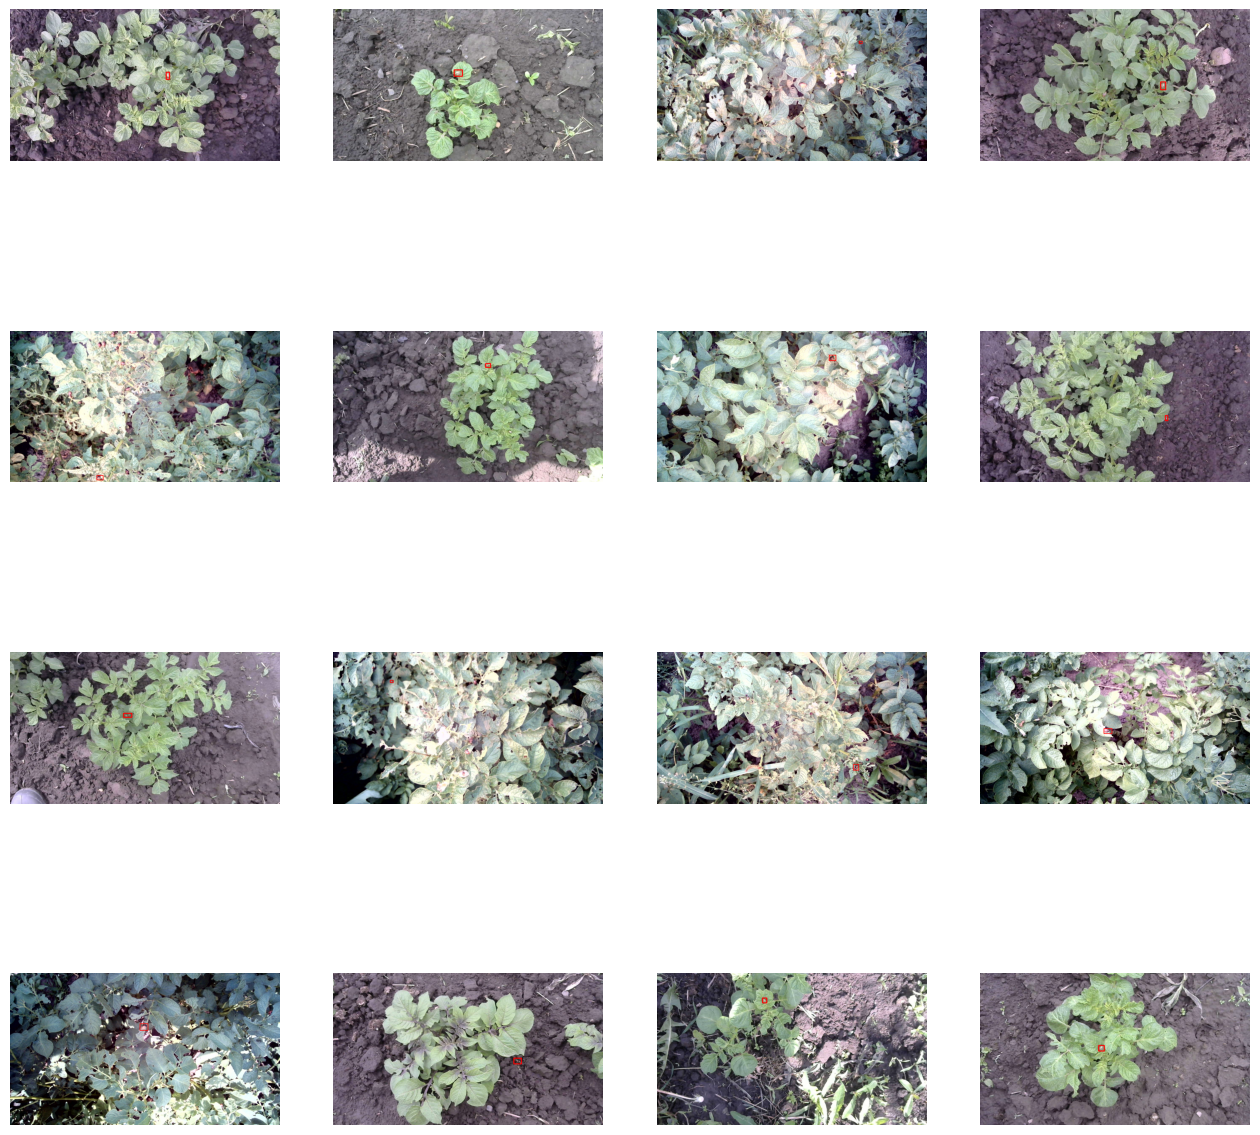

In [ ]:
#images check

import matplotlib.pyplot as plt
import cv2
import os
import random
import pandas as pd
import matplotlib.image as mpimg
import seaborn as sns

image_files = os.listdir(f'{train_dir}/images/')

random_images = random.sample(image_files, 16)

fig, axs = plt.subplots(4, 4, figsize=(16, 16))

for i, image_file in enumerate(random_images):
    row = i // 4
    col = i % 4

    image_path = os.path.join(f'{train_dir}/images/', image_file)
    image = cv2.imread(image_path)

    label_file = os.path.splitext(image_file)[0] + '.txt'
    label_path = os.path.join(f'{train_dir}/labels/', label_file)
    with open(label_path, 'r') as f:
        labels = f.read().strip().split('\n')

    for label in labels:
        if len(label.split()) != 5:
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width/2) * image.shape[1])
        y_min = int((y_center - height/2) * image.shape[0])
        x_max = int((x_center + width/2) * image.shape[1])
        y_max = int((y_center + height/2) * image.shape[0])
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 0, 255), 3)

    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

plt.show()

# Training

In [ ]:
model = YOLO('yolov8n.pt')

results = model.train(data='/content/PotatoBeetleAI/data.yaml',
            epochs = 25,
            imgsz = [1920,1080],
            batch = 8)

100%|██████████| 6.23M/6.23M [00:00<00:00, 245MB/s]
Ultralytics YOLOv8.0.197 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/PotatoBeetleAI/data.yaml, epochs=25, patience=50, batch=8, imgsz=[1920, 1080], save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, ret

In [ ]:
%matplotlib inline

model_ex = YOLO('/content/runs/detect/train/weights/best.pt')

metrics = model_ex.val(data='/content/PotatoBeetleAI/data.yaml')

Ultralytics YOLOv8.0.197 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/PotatoBeetleAI/val/labels.cache... 271 images, 0 backgrounds, 0 corrupt: 100%|██████████| 271/271 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:20<00:00,  1.21s/it]
                   all        271        271      0.401      0.617      0.463      0.223
                beetle        271        123      0.543      0.829      0.679      0.343
                larvae        271        148      0.259      0.405      0.247      0.102
Speed: 11.6ms preprocess, 20.3ms inference, 0.0ms loss, 8.7ms postprocess per image
Results saved to runs/detect/val


# Evaluation

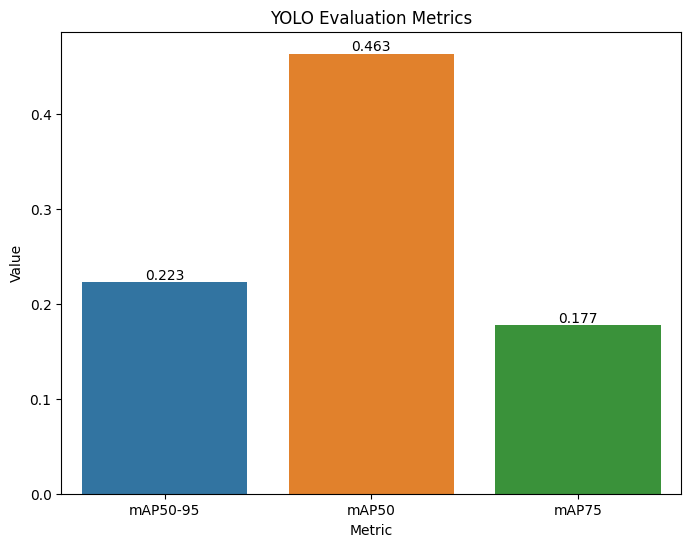

In [ ]:
%matplotlib inline

ax = sns.barplot(x=['mAP50-95', 'mAP50', 'mAP75'], y=[metrics.box.map, metrics.box.map50, metrics.box.map75])

ax.set_title('YOLO Evaluation Metrics')
ax.set_xlabel('Metric')
ax.set_ylabel('Value')

fig = plt.gcf()
fig.set_size_inches(8, 6)

for p in ax.patches:
    ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

plt.show()

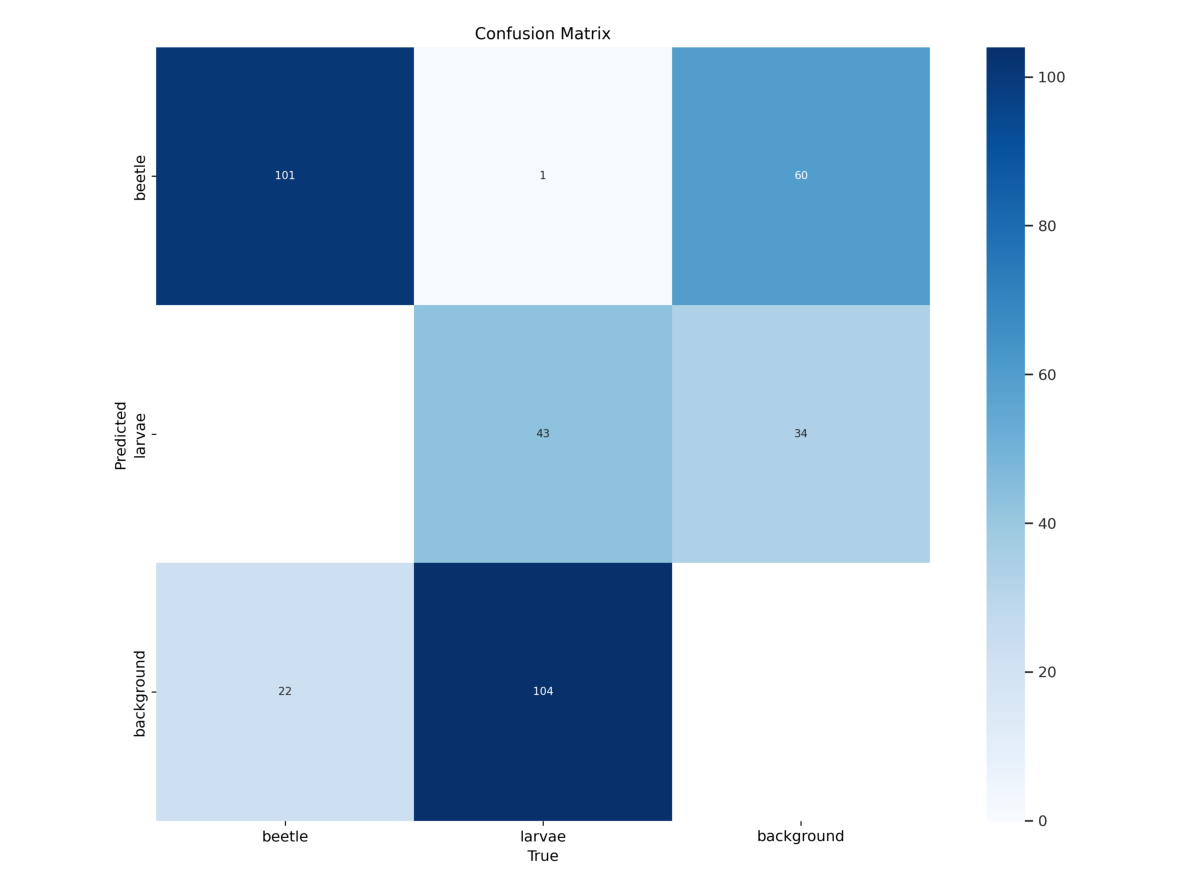

In [ ]:
%matplotlib inline

img = mpimg.imread('/content/runs/detect/train/confusion_matrix.png')

fig, ax = plt.subplots(figsize = (15, 15))

ax.imshow(img)
ax.axis('off');

# Detection

In [ ]:
def detect(img_path):

    img = cv2.imread(img_path)

    detect_result = model(img)

    detect_img = detect_result[0].plot()

    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)

    return detect_img


0: 1088x1920 1 beetle, 65.3ms
Speed: 15.1ms preprocess, 65.3ms inference, 9.9ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 (no detections), 24.1ms
Speed: 15.6ms preprocess, 24.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 beetle, 24.1ms
Speed: 8.8ms preprocess, 24.1ms inference, 1.7ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 larvae, 24.2ms
Speed: 10.9ms preprocess, 24.2ms inference, 1.8ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 larvae, 24.4ms
Speed: 8.8ms preprocess, 24.4ms inference, 1.9ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 (no detections), 24.1ms
Speed: 10.0ms preprocess, 24.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 larvae, 24.1ms
Speed: 7.4ms preprocess, 24.1ms inference, 1.8ms postprocess per image at shape (1, 3, 1088, 1920)

0: 1088x1920 1 larvae, 24.1ms
Speed: 8.9ms preprocess, 24.1ms inference

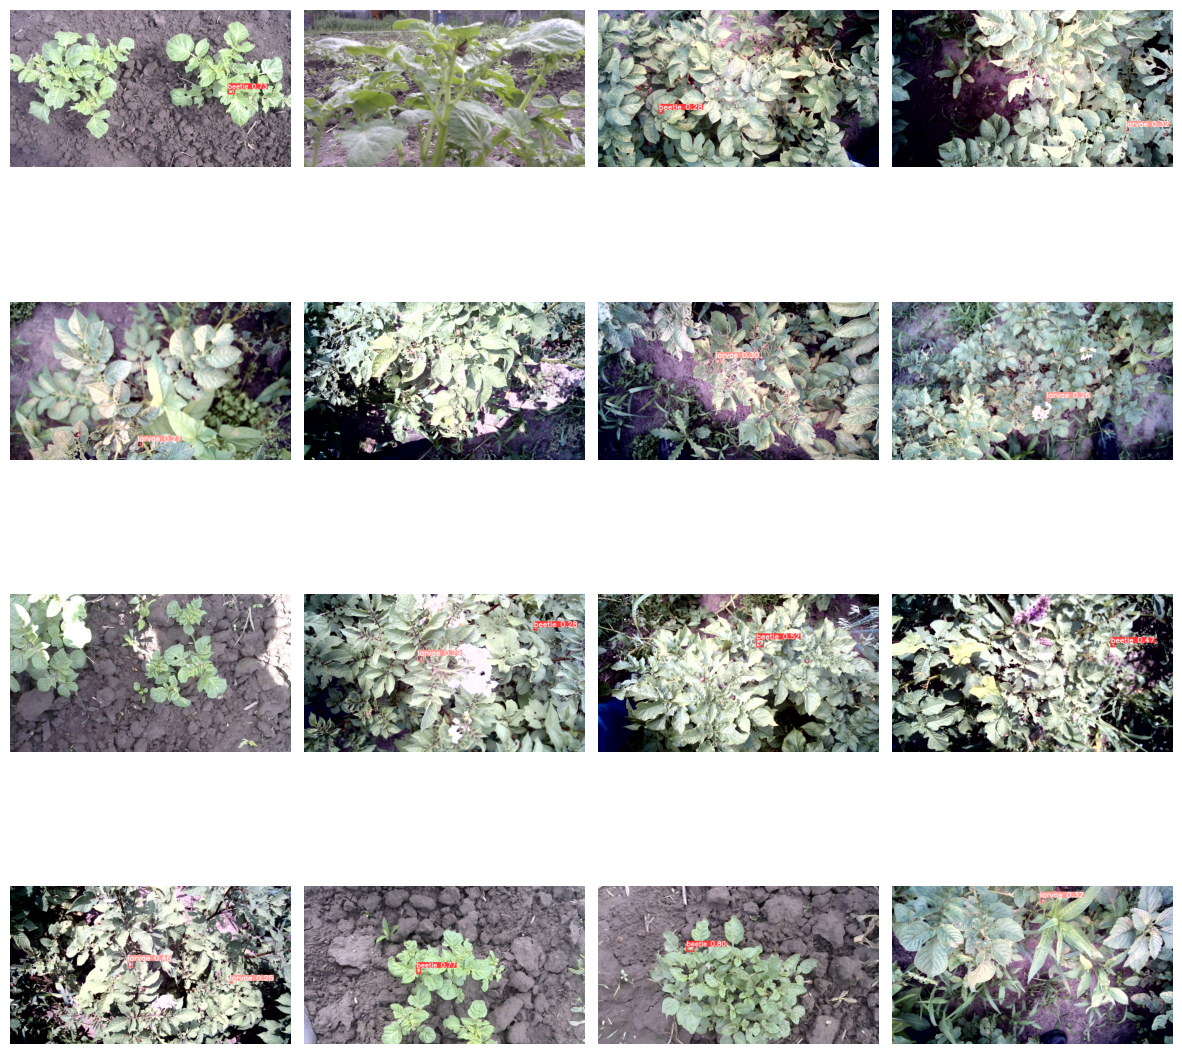

In [ ]:
import random

custom_image_dir = '/content/PotatoBeetleAI/train/images'

image_files = os.listdir(custom_image_dir)

selected_images = random.sample(image_files, 16)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

for i, img_file in enumerate(selected_images):

    row_idx = i // 4
    col_idx = i % 4

    img_path = os.path.join(custom_image_dir, img_file)
    detect_img = detect(img_path)

    axes[row_idx, col_idx].imshow(detect_img)
    axes[row_idx, col_idx].axis('off')

plt.subplots_adjust(wspace=0.05, hspace=0.05)